# 基于深度学习的机器视觉 - 垃圾分类

# 1. 实验介绍
## 1.1 实验背景

自今年 7 月 1 日起，上海市将正式实施 《上海市生活垃圾管理条例》。  
垃圾分类，看似是微不足道的“小事”，实则关系到13亿多人生活环境的改善，理应大力提倡。  
垃圾识别分类数据集中包括玻璃 (glass) 、硬纸板 (cardboard) 、金属 (metal) 、纸 (paper) 、塑料 (plastic) 、一般垃圾 (trash) ，共6个类别。    
生活垃圾由于种类繁多，具体分类缺乏统一标准，大多人在实际操作时会“选择困难”，基于深度学习技术建立准确的分类模型，利用技术手段改善人居环境。    

## 1.2 实验要求
a）建立深度神经网络模型，并尽可能将其调到最佳状态。   
b）绘制深度神经网络模型图、绘制并分析学习曲线。  
c）用准确率等指标对模型进行评估。    

## 1.3 实验环境
可以使用基于 Python 的 OpenCV 库进行图像相关处理，使用 Numpy 库进行相关数值运算，使用 Keras 等框架建立深度学习模型等。

## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

## 1.5 参考资料
OpenCV：https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html  
Numpy：https://www.numpy.org/  
Keras: https://keras.io/

# 2.实验内容
## 2.1 介绍数据集

该数据集包含了 2507 个生活垃圾图片。数据集的创建者将垃圾分为了 6 个类别，分别是：

|序号|中文名|英文名|数据集大小|
|--|--|--|--|
|1|玻璃|glass| 497 |
|2|纸|paper| 590 |
|3|硬纸板|cardboard| 400 |
|4|塑料|plastic| 479 |
|5|金属|metal|407 |
|6|一般垃圾|trash|134 |

+ 物品都是放在白板上在日光/室内光源下拍摄的，压缩后的尺寸为 512 * 384

导入数据集成功后路径：  
data_path = "./datasets/la1ji1fe1nle4ishu4ju4ji22-momodel/dataset-resized"

In [1]:
# 导入相关包
import glob, os

# 数据集路径
data_path = "./dataset-resized"

# 获取数据名称列表
img_list = glob.glob(os.path.join(data_path, '*/*.jpg'))

# 打印数据集总量
print("数据集总数量:", len(img_list))
print("数据路径和名称:",img_list[0])

数据集总数量: 2527
数据路径和名称: ./dataset-resized\cardboard\cardboard1.jpg


In [9]:
os.path.join(data_path, '*\\*.jpg')

'.\\dataset-resized\\*\\*.jpg'

数据集总共有 2507 张图片，现在随机展示其中的 6 张图片。

In [6]:
import random,cv2
import numpy as np
import matplotlib.pyplot as plt

# 从数据名称列表 img_list 中随机选取 6 个。
for i, img_path in enumerate(random.sample(img_list, 6)):
    
    # 读取图片
    img = cv2.imread(img_path)
    
    # 将图片从 BGR 模式转为 RGB 模式
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 将窗口设置为 2 行 3 列 6个子图
    plt.subplot(2, 3, i + 1)
    
    # 展示图片
    plt.imshow(img)
    
    # 不显示坐标尺寸
    # plt.axis('off')

NameError: name 'img_list' is not defined

+ 获取图像形状    
img.shape 可以获得图像的形状，返回值是一个包含行数，列数，通道数的元组

In [3]:
# 随机选取一张图片
path = random.sample(img_list, 1)

# 读取图片
img = cv2.imread(path[0])

# 将图片从 BGR 模式转为 RGB 模式
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# 获取图片的形状
img.shape

(384, 512, 3)

## 2.2 图片预处理


图片生成器 [ImageDataGenerator](https://keras.io/preprocessing/image/): keras.preprocessing.image 模块中的图片生成器，主要用以生成一个 batch 的图像数据，支持实时数据提升。训练时该函数会无限生成数据，直到达到规定的 epoch 次数为止。同时也可以在 batch 中对数据进行增强，扩充数据集大小，增强模型的泛化能力，比如进行旋转，变形，归一化等等。
    
图片生成器的主要方法：
+ fit(x, augment=False, rounds=1)：计算依赖于数据的变换所需要的统计信息(均值方差等)。  

+ flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')：接收 Numpy 数组和标签为参数,生成经过数据提升或标准化后的 batch 数据，并在一个无限循环中不断的返回 batch 数据。  


+ flow_from_directory(directory): 以文件夹路径为参数，会从路径推测 label，生成经过数据提升/归一化后的数据，在一个无限循环中无限产生 batch 数据。

英文参考链接：https://keras.io/preprocessing/image/  
中文参考链接：https://keras-cn.readthedocs.io/en/latest/preprocessing/image/

以上只是对图片生成器进行简单的介绍，详细信息请参考中英文链接。  
根据上面的介绍和我们数据集的特性，我们主要运用 `ImageDataGenerator()` 和 `flow_from_directory()` 方法。我们将数据处理过程封装成为一个函数：

In [2]:
# 导入图片生成器
from keras.preprocessing.image import ImageDataGenerator


def processing_data(data_path, height, width, batch_size=32, validation_split=0.1):
    """
    数据处理
    :param data_path: 带有子目录的数据集路径
    :param height: 图像形状的行数
    :param width: 图像形状的列数
    :param batch_size: batch 数据的大小，整数，默认32。
    :param validation_split: 在 0 和 1 之间浮动。用作测试集的训练数据的比例，默认0.1。
    :return: train_generator, validation_generator: 处理后的训练集数据、验证集数据
    """

    train_data = ImageDataGenerator(
            # 对图片的每个像素值均乘上这个放缩因子，把像素值放缩到0和1之间有利于模型的收敛
            rescale=1. / 255,  
            # 浮点数，剪切强度（逆时针方向的剪切变换角度）
            shear_range=0.1,  
            # 随机缩放的幅度，若为浮点数，则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]
            zoom_range=0.1,
            # 浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度
            width_shift_range=0.1,
            # 浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度
            height_shift_range=0.1,
            # 布尔值，进行随机水平翻转
            horizontal_flip=True,
            # 布尔值，进行随机竖直翻转
            vertical_flip=True,
            # 在 0 和 1 之间浮动。用作验证集的训练数据的比例
            validation_split=validation_split  
    )

    # 接下来生成测试集，可以参考训练集的写法
    validation_data = ImageDataGenerator(
            rescale=1. / 255,
            validation_split=validation_split)

    train_generator = train_data.flow_from_directory(
            # 提供的路径下面需要有子目录
            data_path, 
            # 整数元组 (height, width)，默认：(256, 256)。 所有的图像将被调整到的尺寸。
            target_size=(height, width),
            # 一批数据的大小
            batch_size=batch_size,
            # "categorical", "binary", "sparse", "input" 或 None 之一。
            # 默认："categorical",返回one-hot 编码标签。
            class_mode='categorical',
            # 数据子集 ("training" 或 "validation")
            subset='training', 
            seed=0)
    validation_generator = validation_data.flow_from_directory(
            data_path,
            target_size=(height, width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            seed=0)

    return train_generator, validation_generator

In [19]:
print("NAIVE")

NAIVE


In [5]:
# 数据路径
data_path = "./dataset-resized"

# 图像数据的行数和列数
height, width = 384, 512

# 获取训练数据和验证数据集
train_generator, validation_generator = processing_data(data_path, height, width)

# 通过属性class_indices可获得文件夹名与类的序号的对应字典。 (类别的顺序将按照字母表顺序映射到标签值)。
labels = train_generator.class_indices
print(labels)

# 转换为类的序号与文件夹名对应的字典
labels = dict((v, k) for k, v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [20]:
list(map(lambda x: print(x, type(x)), labels.items()))

(0, 'cardboard') <class 'tuple'>
(1, 'glass') <class 'tuple'>
(2, 'metal') <class 'tuple'>
(3, 'paper') <class 'tuple'>
(4, 'plastic') <class 'tuple'>
(5, 'trash') <class 'tuple'>


[None, None, None, None, None, None]

## 2.3 采用 Keras 建立一个简单的深度神经网络模型
通过 Keras 构建深度学习模型的步骤如下：
+ 定义模型——创建一个模型并添加配置层
+ 编译模型——指定损失函数和优化器，并调用模型的 compile() 函数，完成模型编译。
+ 训练模型——通过调用模型的 fit() 函数来训练模型。
+ 模型预测——调用模型的 evaluate()或者 predict() 等函数对新数据进行预测。

### 2.3.1 常见的创建模型方式

Keras 的核心数据结构是 model，一种组织网络层的方式。最简单的模型是 [Sequential 顺序模型](https://keras.io/getting-started/sequential-model-guide/)，它由多个网络层线性堆叠。对于更复杂的结构，你应该使用 Keras 函数式 API，它允许构建任意的神经网络图。下面先来看看 Sequential 顺序模型：

In [6]:
# 方式一: 使用 .add() 方法将各层添加到模型中
# 导入相关包
from keras.models import Sequential
from keras.layers import Dense, Activation

# 选择模型，选择序贯模型（Sequential())
model = Sequential()

# 构建网络层
# 添加全连接层，输入784维,输出空间维度32
model.add(Dense(32, input_shape=(784,)))

# 添加激活层，激活函数是 relu
model.add(Activation('relu'))

# 打印模型概况
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 方式二：网络层实例的列表构建序贯模型
# 导入相关的包
from keras.models import Sequential
from keras.layers import Dense, Activation

# 选择模型，选择序贯模型（Sequential())
# 通过将网络层实例的列表传递给 Sequential 的构造器，来创建一个 Sequential 模型
model = Sequential([
    Dense(32, input_shape=(784,)),
    Activation('relu')
])

# 打印模型概况
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_6 (Activation)    (None, 32)                0         
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


采用 Keras 函数式模型：

In [7]:
# 方式三：函数式模型
# 导入相关的包
from keras.layers import Input, Dense, Activation
from keras.models import Model

# 输入层，返回一个张量 tensor
inputs = Input(shape=(784,))

# 全连接层，返回一个张量
output_1 = Dense(32)(inputs)

# 激活函数层
predictions= Activation(activation='relu')(output_1)

# 创建一个模型，包含输入层、全连接层和激活层
model = Model(inputs=inputs, outputs=predictions)

# 打印模型概况
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


### 2.3.2 建立深度学习模型

+ 创建一个简单的深度接神经网络模型

In [1]:
# 导入相关包
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import TensorBoard
import time


def dnn_model(input_shape, train_generator, validation_generator, log_dir="results/logs/"):
    """
    该函数实现 Keras 创建深度学习模型的过程
    :param input_shape: 模型数据形状大小，比如:input_shape=(384, 512, 3)
    :param train_generator: 训练集
    :param validation_generator: 验证集
    :param model_save_path: 保存模型的路径
    :param log_dir: 保存模型日志路径
    :return: 返回已经训练好的模型
    """
    # Input 用于实例化 Keras 张量。
    # shape: 一个尺寸元组（整数），不包含批量大小。 例如，shape=(32,) 表明期望的输入是按批次的 32 维向量。
    inputs = Input(shape=input_shape)

    # 将输入展平
    dnn = Flatten()(inputs)

    # Dense 全连接层  实现以下操作：output = activation(dot(input, kernel) + bias)
    # 其中 activation 是按逐个元素计算的激活函数，kernel 是由网络层创建的权值矩阵，
    # 以及 bias 是其创建的偏置向量 (只在 use_bias 为 True 时才有用)。
    dnn = Dense(6)(dnn)
    # 批量标准化层: 在每一个批次的数据中标准化前一层的激活项， 即应用一个维持激活项平均值接近 0，标准差接近 1 的转换。
    # axis: 整数，需要标准化的轴 （通常是特征轴）。默认值是 -1
    dnn = BatchNormalization(axis=-1)(dnn)
    # 将激活函数,输出尺寸与输入尺寸一样，激活函数可以是'softmax'、'sigmoid'等
    dnn = Activation('sigmoid')(dnn)
    # Dropout 包括在训练中每次更新时，将输入单元的按比率随机设置为 0, 这有助于防止过拟合。
    # rate: 在 0 和 1 之间浮动。需要丢弃的输入比例。
    dnn = Dropout(0.25)(dnn)

    dnn = Dense(12)(dnn)
    dnn = BatchNormalization(axis=-1)(dnn)
    dnn = Activation('relu')(dnn)
    dnn = Dropout(0.5)(dnn)

    dnn = Dense(6)(dnn)
    dnn = BatchNormalization(axis=-1)(dnn)
    dnn = Activation('softmax')(dnn)

    outputs = dnn

    # 生成一个函数型模型
    model = Model(inputs=inputs, outputs=outputs)

    # 编译模型, 采用 compile 函数: https://keras.io/models/model/#compile
    model.compile(
            # 是优化器, 主要有Adam、sgd、rmsprop等方式。
            optimizer='Adam',
            # 损失函数,多分类采用 categorical_crossentropy
            loss='categorical_crossentropy',
            # 是除了损失函数值之外的特定指标, 分类问题一般都是准确率
            metrics=['accuracy'])

#     可视化，TensorBoard 是由 Tensorflow 提供的一个可视化工具。
#     tensorboard = TensorBoard(log_dir)

    # 训练模型, fit_generator函数:https://keras.io/models/model/#fit_generator
    # 利用Python的生成器，逐个生成数据的batch并进行训练。
    # callbacks: 实例列表。在训练时调用的一系列回调。详见 https://keras.io/callbacks/。
    d = model.fit_generator(
            # 一个生成器或 Sequence 对象的实例
            generator=train_generator,
            # epochs: 整数，数据的迭代总轮数。
            epochs=5,
            # 一个epoch包含的步数,通常应该等于你的数据集的样本数量除以批量大小。
            steps_per_epoch=2259 // 32,
            # 验证集
            validation_data=validation_generator,
            # 在验证集上,一个epoch包含的步数,通常应该等于你的数据集的样本数量除以批量大小。
            validation_steps=248 // 32,)
        #     callbacks=[tensorboard])
    # 模型保存
#     model.save(model_save_path)

    return d, model


Using TensorFlow backend.


+ 模型训练过程和模型概况

In [3]:
# 开始时间
start = time.perf_counter()

# 数据预处理
data_path = "./dataset-resized"

# 图像数据的行数和列数
height, width = 384, 512

# 获取训练数据和验证数据
train_generator, validation_generator = processing_data(data_path, height, width)

# 定义模型输入大小
input_shape=(384, 512, 3)

# 训练模型，获取训练过程和训练后的模型
res,model = dnn_model(input_shape, train_generator, validation_generator)

model.save('./results/dnn.h5')

# 打印模型概况和模型训练总数长
model.summary()
print("模型训练总时长：",time.perf_counter()-start)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Epoch 1/5
70/70 [==============================] - 88s 1s/step - loss: 2.0519 - accuracy: 0.2107 - val_loss: 1.7980 - val_accuracy: 0.2143
Epoch 2/5
70/70 [==============================] - 92s 1s/step - loss: 1.9938 - accuracy: 0.1985 - val_loss: 1.7424 - val_accuracy: 0.2283
Epoch 3/5
70/70 [==============================] - 96s 1s/step - loss: 1.9041 - accuracy: 0.2306 - val_loss: 1.7323 - val_accuracy: 0.2374
Epoch 4/5
70/70 [==============================] - 96s 1s/step - loss: 1.8760 - accuracy: 0.2378 - val_loss: 1.7525 - val_accuracy: 0.2055
Epoch 5/5
70/70 [==============================] - 95s 1s/step - loss: 1.8239 - accuracy: 0.2468 - val_loss: 1.6939 - val_accuracy: 0.2740


OSError: Unable to create file (unable to open file: name = './results/dnn.h', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [17]:
model.save("results/dnn.h5")

In [11]:
import os
os.getcwd()

'd:\\Documents\\Materials\\DENDEN\\PROJ\\Python\\smallCNN'

+ 模型训练过程图形化

In [7]:
def plot_training_history(res):
    """
    绘制模型的训练结果
    :param res: 模型的训练结果
    :return:
    """
    # 绘制模型训练过程的损失和平均损失
    # 绘制模型训练过程的损失值曲线，标签是 loss
    plt.plot(res.history['loss'], label='loss')
    
    # 绘制模型训练过程中的平均损失曲线，标签是 val_loss
    plt.plot(res.history['val_loss'], label='val_loss')
    
    # 绘制图例,展示出每个数据对应的图像名称和图例的放置位置
    plt.legend(loc='upper right')
    
    # 展示图片
    plt.show()

    # 绘制模型训练过程中的的准确率和平均准确率
    # 绘制模型训练过程中的准确率曲线，标签是 acc
    plt.plot(res.history['accuracy'], label='accuracy')
    
    # 绘制模型训练过程中的平均准确率曲线，标签是 val_acc
    plt.plot(res.history['val_accuracy'], label='val_accuracy')
    
    # 绘制图例,展示出每个数据对应的图像名称，图例的放置位置为默认值。
    plt.legend()
    
    # 展示图片
    plt.show()

In [8]:
import os
os.getcwd()

'd:\\Documents\\Materials\\DENDEN\\PROJ\\Python\\smallCNN'

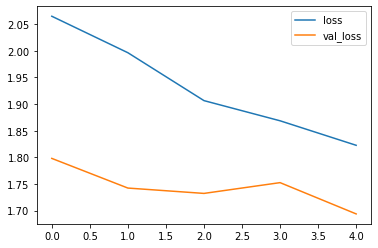

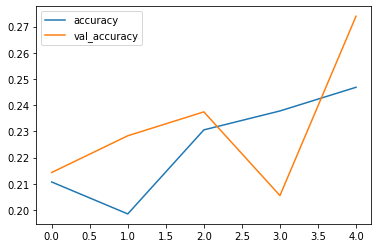

In [9]:
# 绘制模型训练过程曲线
plot_training_history(res) 

+ 加载模型和模型评估




In [21]:
from keras.models import load_model


def load_and_model_prediction(validation_generator):
    """
    加载模型和模型评估，打印验证集的 loss 和准确度
    :param validation_generator: 预测数据
    :return: 
    """
    # 加载模型
    model = load_model('results/dnn.h5')
    # 获取验证集的 loss 和 accuracy
    loss, accuracy = model.evaluate_generator(validation_generator)
    print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy * 100))

In [19]:
# 打印模型评估的结果
load_and_model_prediction(validation_generator)

OSError: Unable to open file (unable to open file: name = '/results/dnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

+ 模型预测和展示模型预测结果


In [ ]:
from keras.models import load_model


def plot_load_and_model_prediction(validation_generator, labels):
    """
    加载模型、模型预测并展示模型预测结果等
    :param validation_generator: 预测数据
    :param labels: 数据标签
    :return:
    """
    # 加载模型
    model = load_model('results/dnn.h5')

    # 测试集数据与标签
    test_x, test_y = validation_generator.__getitem__(2)

    # 预测值
    preds = model.predict(test_x)

    # 绘制预测图像的预测值和真实值，定义画布
    plt.figure(figsize=(16, 16))
    for i in range(16):
        # 绘制各个子图
        plt.subplot(4, 4, i + 1)

        # 图片名称
        plt.title(
                'pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))

        # 展示图片
        plt.imshow(test_x[i])

In [ ]:
# 展示模型预测结果
plot_load_and_model_prediction(validation_generator, labels)

+ 加载模型并预测输入图片的类别

In [ ]:
import os
from keras.models import load_model
from keras.preprocessing import image
import numpy as np


def load_and_predict(img):
    """
    加载模型并预测一张图片的类别
    :param img: PIL.Image 对象
    :return: string, 模型识别图片的类别, 
            共 'cardboard','glass','metal','paper','plastic','trash' 6 个类别
    """
    # 加载模型, 默认'results/dnn.h5',请填写你的最佳模型
    model_path = 'results/dnn.h5'
    model = load_model(model_path)

    # 把图片转换成为numpy数组
    img = image.img_to_array(img)
    
    # 图片放缩
    img = 1.0/255 * img

    # expand_dims的作用是把img.shape转换成(1, img.shape[0], img.shape[1], img.shape[2])
    x = np.expand_dims(img, axis=0)

    # 模型预测
    y = model.predict(x)

    # 获取labels
    labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

    # 获取输入图片的类别
    y_predict = labels[np.argmax(y)]

    # 返回图片的类别
    return y_predict

In [ ]:
from keras.preprocessing import image

# 输入图片路径和名称
file_path = 'test.jpg'

# 打印该张图片的类别
img = image.load_img(file_path)

print(load_and_predict(img))

## 2.4 作业

通过对以上步骤流程的了解，相信大家对深度学习有了深刻的认识，但是模型比较简单，准确率也不高，大家可以试着写自己的深度学习模型，并将其调到最佳状态。在训练模型等过程中如果需要**保存数据、模型**等请写到 **results** 文件夹。

### 2.4.1 训练深度学习模型

深度学习模型训练流程, 包含数据处理、创建模型、训练模型、模型保存、评价模型等。  
如果对训练出来的模型不满意, 你可以通过调整模型的参数等方法重新训练模型, 直至训练出你满意的模型。  
如果你对自己训练出来的模型非常满意, 则可以提交作业!  

注意：

1. 你可以在我们准好的接口中实现深度学习模型（若使用可以修改函数接口），也可以自己实现深度学习模型。
2. 写好代码后可以在 Py 文件中使用 GPU 进行模型训练。

===========================================  实现自己的深度学习模型代码答题区域  ===========================================

双击下方区域开始编写  **数据处理**、**创建模型**、**训练模型**、**保存模型**  和  **评估模型**  等部分的代码，请勿在别的位置作答

In [ ]:
def processing_data(data_path):
    """
    数据处理
    :param data_path: 数据集路径
    :return: train, test:处理后的训练集数据、测试集数据
    """
    # -------------------------- 实现数据处理部分代码 ----------------------------

    # ------------------------------------------------------------------------
    train_data, test_data = None, None
    return train_data, test_data


def model(train_data, test_data, save_model_path):
    """
    创建、训练和保存深度学习模型
    :param train_data: 训练集数据
    :param test_data: 测试集数据
    :param save_model_path: 保存模型的路径和名称
    :return:
    """
    # --------------------- 实现模型创建、训练和保存等部分的代码 ---------------------

    # 保存模型（请写好保存模型的路径及名称）
    # -------------------------------------------------------------------------

    return model


def evaluate_mode(test_data, save_model_path):
    """
    加载模型和评估模型
    可以实现，比如: 模型训练过程中的学习曲线，测试集数据的loss值、准确率及混淆矩阵等评价指标！
    主要步骤:
        1.加载模型(请填写你训练好的最佳模型),
        2.对自己训练的模型进行评估

    :param test_data: 测试集数据
    :param save_model_path: 加载模型的路径和名称,请填写你认为最好的模型
    :return:
    """
    # ----------------------- 实现模型加载和评估等部分的代码 -----------------------

    # ---------------------------------------------------------------------------


def main():
    """
    深度学习模型训练流程,包含数据处理、创建模型、训练模型、模型保存、评价模型等。
    如果对训练出来的模型不满意,你可以通过调整模型的参数等方法重新训练模型,直至训练出你满意的模型。
    如果你对自己训练出来的模型非常满意,则可以提交作业!
    :return:
    """
    data_path = None  # 数据集路径
    save_model_path = None  # 保存模型路径和名称

    # 获取数据
    train_data, test_data = processing_data(data_path)

    # 创建、训练和保存模型
    model(train_data, test_data, save_model_path)

    # 评估模型
    evaluate_mode(test_data, save_model_path)


if __name__ == '__main__':
    main()

### 2.4.2 模型预测


注意：
1. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
2. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
4. `predict()`函数的输入和输出请不要改动。
5. 作业测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

===========================================  **模型预测代码答题区域**  ===========================================  
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os


# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 dnn.h5 模型，则 model_path = 'results/dnn.h5'
model_path = None

# 加载模型，如果采用keras框架训练模型，则 model=load_model(model_path)
model = None
    
# ---------------------------------------------------------------------------

def predict(img):
    """
    加载模型和模型预测
    主要步骤:
        1.图片处理
        2.用加载的模型预测图片的类别
    :param img: PIL.Image 对象
    :return: string, 模型识别图片的类别, 
            共 'cardboard','glass','metal','paper','plastic','trash' 6 个类别
    """
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 获取图片的类别，共 'cardboard','glass','metal','paper','plastic','trash' 6 个类别
    # 把图片转换成为numpy数组
    img = image.img_to_array(img)
    

    # 获取输入图片的类别
    y_predict = None

    # -------------------------------------------------------------------------
    
    # 返回图片的类别
    return y_predict

In [ ]:
from keras.preprocessing import image

# 输入图片路径和名称
img_path = 'test.jpg'

# 打印该张图片的类别
img = image.load_img(img_path)
print(predict(img))